**Ridge Regression Machine Learning model**
### Methodology
1. **Load Data**: Batting, Master, Salaries, Teams tables.
2. **Preprocess**: Calculate Age, filter for 1999-2015 era.
3. **Feature Engineering**:
   - **OPS**: On-base Plus Slugging.
   - **Relative OPS**: Adjusted for league offensive environment.
   - **Aging Curve**: Age and Age².
   - **Context**: Salary, Strikeout Rate, Walk Rate.
4. **Modeling**: Train predict Next Year OPS.
5. **Analysis**: Identify top underperformers/overperformers.

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

DATA_DIR = os.path.expanduser('~/Downloads/Capstone Hitters MLB')
MIN_AB = 100
START_YEAR = 1999
END_YEAR = 2015

In [39]:
def load_data(data_dir):
    try:
        batting = pd.read_csv(os.path.join(data_dir, 'Batting.csv'))
        master_path = os.path.join(data_dir, 'Master.csv')
        if not os.path.exists(master_path):
             master_path = os.path.join(data_dir, 'MAster.csv')
        master = pd.read_csv(master_path)
        salaries = pd.read_csv(os.path.join(data_dir, 'Salaries.csv'))
        teams = pd.read_csv(os.path.join(data_dir, 'Teams.csv'))
        print("Data Loaded Successfully.")
        return batting, master, salaries, teams
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

batting, master, salaries, teams = load_data(DATA_DIR)

Data Loaded Successfully.


- Calculate **Age**
- Calculate **OPS** and **Relative OPS** vs League Average

In [40]:
def preprocess_and_engineer(batting, master, teams, salaries, start_year, end_year):
    df = pd.merge(batting, master[['playerID', 'birthYear']], on='playerID', how='inner')
    df = df[(df['yearID'] >= start_year) & (df['yearID'] <= end_year)].copy()
    df['Age'] = df['yearID'] - df['birthYear']

    for col in ['H', 'BB', 'HBP', 'AB', 'SF', '2B', '3B', 'HR', 'SO']:
        if col in df.columns:
             df[col] = df[col].fillna(0)
    df = df[df['AB'] >= MIN_AB].copy()

    obp_denom = df['AB'] + df['BB'] + df['HBP'] + df['SF']
    df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / obp_denom
    df['TB'] = df['H'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']
    df['SLG'] = df['TB'] / df['AB']
    df['OPS'] = df['OBP'] + df['SLG']

    league_stats = teams.groupby('yearID').agg({
        'H': 'sum', 'BB': 'sum', 'HBP': 'sum', 'AB': 'sum',
        'SF': 'sum', '2B': 'sum', '3B': 'sum', 'HR': 'sum'
    }).reset_index()
    league_stats['L_OBP'] = (league_stats['H'] + league_stats['BB'] + league_stats['HBP']) / (league_stats['AB'] + league_stats['BB'] + league_stats['HBP'] + league_stats['SF'])
    league_stats['L_SLG'] = (league_stats['H'] + 2*league_stats['2B'] + 3*league_stats['3B'] + 4*league_stats['HR']) / league_stats['AB']
    league_stats['League_OPS'] = league_stats['L_OBP'] + league_stats['L_SLG']

    df = pd.merge(df, league_stats[['yearID', 'League_OPS']], on='yearID', how='left')
    df['Relative_OPS'] = df['OPS'] - df['League_OPS']

    df['SO_Rate'] = df['SO'] / df['AB']
    df['BB_Rate'] = df['BB'] / df['AB']
    df['Age_Squared'] = df['Age'] ** 2

    if not salaries.empty:
        df = pd.merge(df, salaries[['playerID', 'yearID', 'salary']], on=['playerID', 'yearID'], how='left')
        df['salary'] = df.groupby('yearID')['salary'].transform(lambda x: x.fillna(x.median()))
        df['salary'] = df['salary'].fillna(df['salary'].median())
    else:
        df['salary'] = 0

    df = df.sort_values(['playerID', 'yearID'])
    df['Next_Year_OPS'] = df.groupby('playerID')['OPS'].shift(-1)

    return df.dropna(subset=['Next_Year_OPS'])

df = preprocess_and_engineer(batting, master, teams, salaries, START_YEAR, END_YEAR)
print(f"data prep is done. {len(df)} player-records are prepped.")
df.head()

data prep is done. 5997 player-records are prepped.


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,TB,SLG,OPS,League_OPS,Relative_OPS,SO_Rate,BB_Rate,Age_Squared,salary,Next_Year_OPS
0,abbotku01,1999,1,COL,NL,96,286.0,41.0,78.0,17.0,...,150.0,0.524476,0.834707,0.866463,-0.031757,0.241259,0.055944,900.0,900000.0,0.760944
899,abernbr01,2001,1,TBA,AL,79,304.0,43.0,82.0,17.0,...,139.0,0.457237,0.785550,0.850273,-0.064723,0.115132,0.088816,576.0,1500000.0,0.651157
1,abreubo01,1999,1,PHI,NL,152,546.0,118.0,183.0,35.0,...,366.0,0.670330,1.115949,0.866463,0.249486,0.206960,0.199634,625.0,400000.0,1.103676
443,abreubo01,2000,1,PHI,NL,154,576.0,103.0,182.0,42.0,...,396.0,0.687500,1.103676,0.874990,0.228687,0.201389,0.173611,676.0,2933333.0,1.077139
900,abreubo01,2001,1,PHI,NL,162,588.0,118.0,170.0,48.0,...,402.0,0.683673,1.077139,0.850273,0.226866,0.232993,0.180272,729.0,4983000.0,1.066985


Train Model: Ridge Regression
Ridge Regression is used to prevent overfitting. 
Features: `Age`, `Age_Squared`, `SO_Rate`, `BB_Rate`, `Relative_OPS`, `salary`.

In [43]:
features = ['Age', 'Age_Squared', 'SO_Rate', 'BB_Rate', 'Relative_OPS', 'salary']
target = 'Next_Year_OPS'

model_data = df.dropna(subset=features).copy()
X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Ridge Regression Model on {len(X_train)} player-records.")
model = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" Model Trained Successfully:")
print(f"   R² Score (Signal): {r2:.4f}")
print(f"   Avg. Error (MAE): {mae:.4f} OPS points")
print(f"   Accuracy (MAPE): {100 - (mape * 100):.2f}%")

Training Ridge Regression Model on 4797 player-records.
 Model Trained Successfully:
   R² Score (Signal): 0.2770
   Avg. Error (MAE): 0.0879 OPS points
   Accuracy (MAPE): 88.96%


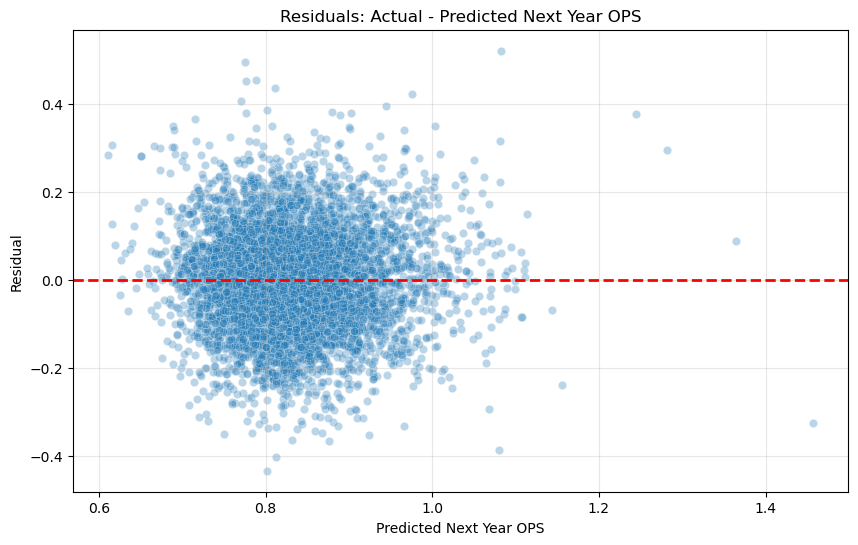

In [44]:
X_full_scaled = scaler.transform(X)
model_data['Predicted_Next_Year_OPS'] = model.predict(X_full_scaled)
model_data['Residual'] = model_data['Next_Year_OPS'] - model_data['Predicted_Next_Year_OPS']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted_Next_Year_OPS', y='Residual', data=model_data, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals: Actual - Predicted Next Year OPS')
plt.xlabel('Predicted Next Year OPS')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)
plt.show()

Top Underperformers for 2015 based on 2014 data

In [46]:
def analyze_underperformers(df, master, year):
    subset = df[df['yearID'] == year].copy()
    if subset.empty:
        print(f" No data found for year {year}")
        return

    underperformers = subset.sort_values('Residual').head(10)
    final_list = pd.merge(underperformers, master[['playerID', 'nameFirst', 'nameLast']], on='playerID')

    print(f"\n📉 Top 10 Underperformers in {year+1} Based on {year} data:")
    display(final_list[['nameFirst', 'nameLast', 'yearID', 'Next_Year_OPS', 'Predicted_Next_Year_OPS', 'Residual']])

analyze_underperformers(model_data, master, 2014)


📉 Top 10 Underperformers in 2015 (Based on 2014 data):


,nameFirst,nameLast,yearID,Next_Year_OPS,Predicted_Next_Year_OPS,Residual
0,Coco,Crisp,2014,0.521640,0.842078,-0.320438
1,Austin,Jackson,2014,0.553945,0.864802,-0.310857
2,Danny,Santana,2014,0.589400,0.878224,-0.288824
3,Rene,Rivera,2014,0.552302,0.830548,-0.278246
4,Stephen,Drew,2014,0.569355,0.808978,-0.239623
5,Victor,Martinez,2014,0.737395,0.976916,-0.239522
6,Mike,Morse,2014,0.638362,0.868746,-0.230384
7,Matthew,Joyce,2014,0.636457,0.866576,-0.230119
8,Jon,Jay,2014,0.596261,0.820222,-0.223961
9,Adam,LaRoche,2014,0.710638,0.930609,-0.219971


In [47]:
def analyze_overperformers(df, master, year):
    subset = df[df['yearID'] == year].copy()
    if subset.empty:
        print(f"No data found for year {year}")
        return

    overperformers = subset.sort_values('Residual', ascending=False).head(10)
    
    final_list = pd.merge(overperformers, master[['playerID', 'nameFirst', 'nameLast']], on='playerID')

    print(f"\n Top 10 Overperformers in {year+1} (Based on {year} data):")
    display(final_list[['nameFirst', 'nameLast', 'yearID', 'Next_Year_OPS', 'Predicted_Next_Year_OPS', 'Residual']])

analyze_overperformers(model_data, master, 2014)


 Top 10 Overperformers in 2015 (Based on 2014 data):


,nameFirst,nameLast,yearID,Next_Year_OPS,Predicted_Next_Year_OPS,Residual
0,Bryce,Harper,2014,1.264467,0.888881,0.375587
1,Ryan,Raburn,2014,1.080896,0.715015,0.365881
2,Jackie,Bradley,2014,0.972655,0.753877,0.218778
3,Chris,Colabello,2014,0.991291,0.777021,0.214270
4,Randal,Grichuk,2014,1.022070,0.819892,0.202178
5,Danny,Valencia,2014,0.961025,0.761480,0.199545
6,Josh,Donaldson,2014,1.074171,0.878764,0.195407
7,Gerardo,Parra,2014,1.003246,0.824040,0.179206
8,Martin,Prado,2014,0.997421,0.819871,0.177550
9,David,Peralta,2014,1.007737,0.836647,0.171090
